Creator: Dhanajit Brahma

Adapted from the original implementation in tensorflow from here: https://github.com/jsyoon0823/GAIN

Generative Adversarial Imputation Networks (GAIN) Implementation on Letter and Spam Dataset

Reference: J. Yoon, J. Jordon, M. van der Schaar, "GAIN: Missing Data Imputation using Generative Adversarial Nets," ICML, 2018.

In [75]:
#%% Packages
import torch
import numpy as np
# from tqdm import tqdm
from tqdm.notebook import tqdm_notebook as tqdm
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

In [64]:
dataset_file = 'Spam.csv'  # 'Letter.csv' for Letter dataset an 'Spam.csv' for Spam dataset
use_gpu = False  # set it to True to use GPU and False to use CPU

if use_gpu:
    torch.cuda.set_device(0)

In [65]:
#%% System Parameters
# 1. Mini batch size
mb_size = 32
# 2. Missing rate
p_miss = 0.2
# 3. Hint rate
p_hint = 0.9
# 4. Loss Hyperparameters
alpha = 10
# 5. Train Rate
train_rate = 0.8

#%% Data

# Data generation
Data = np.loadtxt(dataset_file, delimiter=",",skiprows=1)

# Parameters
No = len(Data)
Dim = len(Data[0,:])

# Hidden state dimensions
H_Dim1 = Dim
H_Dim2 = Dim

# Normalization (0 to 1)
Min_Val = np.zeros(Dim)
Max_Val = np.zeros(Dim)

for i in range(Dim):
    Min_Val[i] = np.min(Data[:,i])
    Data[:,i] = Data[:,i] - np.min(Data[:,i])
    Max_Val[i] = np.max(Data[:,i])
    Data[:,i] = Data[:,i] / (np.max(Data[:,i]) + 1e-6)    

#%% Missing introducing
p_miss_vec = p_miss * np.ones((Dim,1)) 
   
Missing = np.zeros((No,Dim))

for i in range(Dim):
    A = np.random.uniform(0., 1., size = [len(Data),])
    B = A > p_miss_vec[i]
    Missing[:,i] = 1.*B

    
#%% Train Test Division    
   
idx = np.random.permutation(No)

Train_No = int(No * train_rate)
Test_No = No - Train_No
    
# Train / Test Features
trainX = Data[idx[:Train_No],:]
testX = Data[idx[Train_No:],:]

# Train / Test Missing Indicators
trainM = Missing[idx[:Train_No],:]
testM = Missing[idx[Train_No:],:]

#%% Necessary Functions

# 1. Xavier Initialization Definition
# def xavier_init(size):
#     in_dim = size[0]
#     xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
#     return tf.random_normal(shape = size, stddev = xavier_stddev)
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    return np.random.normal(size = size, scale = xavier_stddev)
    
# Hint Vector Generation
def sample_M(m, n, p):
    A = np.random.uniform(0., 1., size = [m, n])
    B = A > p
    C = 1.*B
    return C
   

### GAIN Architecture   
GAIN Consists of 3 Components
- Generator
- Discriminator
- Hint Mechanism

In [66]:
#%% 1. Discriminator
if use_gpu is True:
    D_W1 = torch.tensor(xavier_init([Dim*2, H_Dim1]),requires_grad=True, device="cuda")     # Data + Hint as inputs
    D_b1 = torch.tensor(np.zeros(shape = [H_Dim1]),requires_grad=True, device="cuda")

    D_W2 = torch.tensor(xavier_init([H_Dim1, H_Dim2]),requires_grad=True, device="cuda")
    D_b2 = torch.tensor(np.zeros(shape = [H_Dim2]),requires_grad=True, device="cuda")

    D_W3 = torch.tensor(xavier_init([H_Dim2, Dim]),requires_grad=True, device="cuda")
    D_b3 = torch.tensor(np.zeros(shape = [Dim]),requires_grad=True, device="cuda")       # Output is multi-variate
else:
    D_W1 = torch.tensor(xavier_init([Dim*2, H_Dim1]),requires_grad=True)     # Data + Hint as inputs
    D_b1 = torch.tensor(np.zeros(shape = [H_Dim1]),requires_grad=True)

    D_W2 = torch.tensor(xavier_init([H_Dim1, H_Dim2]),requires_grad=True)
    D_b2 = torch.tensor(np.zeros(shape = [H_Dim2]),requires_grad=True)

    D_W3 = torch.tensor(xavier_init([H_Dim2, Dim]),requires_grad=True)
    D_b3 = torch.tensor(np.zeros(shape = [Dim]),requires_grad=True)       # Output is multi-variate

theta_D = [D_W1, D_W2, D_W3, D_b1, D_b2, D_b3]

#%% 2. Generator
if use_gpu is True:
    G_W1 = torch.tensor(xavier_init([Dim*2, H_Dim1]),requires_grad=True, device="cuda")     # Data + Mask as inputs (Random Noises are in Missing Components)
    G_b1 = torch.tensor(np.zeros(shape = [H_Dim1]),requires_grad=True, device="cuda")

    G_W2 = torch.tensor(xavier_init([H_Dim1, H_Dim2]),requires_grad=True, device="cuda")
    G_b2 = torch.tensor(np.zeros(shape = [H_Dim2]),requires_grad=True, device="cuda")

    G_W3 = torch.tensor(xavier_init([H_Dim2, Dim]),requires_grad=True, device="cuda")
    G_b3 = torch.tensor(np.zeros(shape = [Dim]),requires_grad=True, device="cuda")
else:
    G_W1 = torch.tensor(xavier_init([Dim*2, H_Dim1]),requires_grad=True)     # Data + Mask as inputs (Random Noises are in Missing Components)
    G_b1 = torch.tensor(np.zeros(shape = [H_Dim1]),requires_grad=True)

    G_W2 = torch.tensor(xavier_init([H_Dim1, H_Dim2]),requires_grad=True)
    G_b2 = torch.tensor(np.zeros(shape = [H_Dim2]),requires_grad=True)

    G_W3 = torch.tensor(xavier_init([H_Dim2, Dim]),requires_grad=True)
    G_b3 = torch.tensor(np.zeros(shape = [Dim]),requires_grad=True)

theta_G = [G_W1, G_W2, G_W3, G_b1, G_b2, G_b3]

## GAIN Functions

In [67]:
#%% 1. Generator
def generator(new_x,m):
    inputs = torch.cat(dim = 1, tensors = [new_x,m])  # Mask + Data Concatenate
    G_h1 = F.relu(torch.matmul(inputs, G_W1) + G_b1)
    G_h2 = F.relu(torch.matmul(G_h1, G_W2) + G_b2)   
    G_prob = torch.sigmoid(torch.matmul(G_h2, G_W3) + G_b3) # [0,1] normalized Output
    
    return G_prob

#%% 2. Discriminator
def discriminator(new_x, h):
    inputs = torch.cat(dim = 1, tensors = [new_x,h])  # Hint + Data Concatenate
    D_h1 = F.relu(torch.matmul(inputs, D_W1) + D_b1)  
    D_h2 = F.relu(torch.matmul(D_h1, D_W2) + D_b2)
    D_logit = torch.matmul(D_h2, D_W3) + D_b3
    D_prob = torch.sigmoid(D_logit)  # [0,1] Probability Output
    
    return D_prob

#%% 3. Other functions
# Random sample generator for Z
def sample_Z(m, n):
    return np.random.uniform(0., 0.01, size = [m, n])        

# Mini-batch generation
def sample_idx(m, n):
    A = np.random.permutation(m)
    idx = A[:n]
    return idx

In [68]:
def calculate_columnwise_kl(real_data, fake_data):
    kl_divergences = []
    
    for col_idx in range(real_data.shape[1]):  # Iterate over columns
        real_column = real_data[:, col_idx]
        fake_column = fake_data[:, col_idx]
        
        # Calculate mean and covariance for each distribution
        mean_real = torch.mean(real_column)
        cov_real = torch.diag(torch.var(real_column, unbiased=False))
        
        mean_fake = torch.mean(fake_column)
        cov_fake = torch.diag(torch.var(fake_column, unbiased=False))
        
        # Calculate KL divergence using the formula
        kl_div = 0.5 * (torch.trace(torch.inverse(cov_fake) @ cov_real) +
                        (mean_fake - mean_real).T @ torch.inverse(cov_fake) @ (mean_fake - mean_real) -
                        real_data.shape[1] + torch.logdet(cov_fake) - torch.logdet(cov_real))
        
        kl_divergences.append(kl_div.item())
    
    return kl_divergences

In [69]:
import torch.nn.functional as F
input = F.log_softmax(torch.randn(3, 5, requires_grad=True), dim=1)
target = F.softmax(torch.rand(3, 5), dim=1)
kl_loss = F.kl_div(input, target,reduction="batchmean")
print(kl_loss)


tensor(0.3002, grad_fn=<DivBackward0>)


## GAIN Losses

In [70]:
def discriminator_loss(M, New_X, H):
    # Generator
    G_sample = generator(New_X,M)
    # Combine with original data
    Hat_New_X = New_X * M + G_sample * (1-M)

    # Discriminator
    D_prob = discriminator(Hat_New_X, H)

    #%% Loss
    D_loss = -torch.mean(M * torch.log(D_prob + 1e-8) + (1-M) * torch.log(1. - D_prob + 1e-8))
    return D_loss

def generator_loss(X, M, New_X, H):
    #%% Structure
    # Generator
    G_sample = generator(New_X,M)

    # Combine with original data
    Hat_New_X = New_X * M + G_sample * (1-M)

    # Discriminator
    D_prob = discriminator(Hat_New_X, H)

    #%% Loss
    G_loss1 = -torch.mean((1-M) * torch.log(D_prob + 1e-8))
    MSE_train_loss = torch.mean((M * New_X - M * G_sample)**2) / torch.mean(M)

    kl_loss = F.kl_div(X, G_sample,reduction="batchmean")

    G_loss = G_loss1 + alpha * MSE_train_loss + kl_loss

    #%% MSE Performance metric
    MSE_test_loss = torch.mean(((1-M) * X - (1-M)*G_sample)**2) / torch.mean(1-M)
    return G_loss, MSE_train_loss, MSE_test_loss,kl_loss
    
def test_loss(X, M, New_X):
    #%% Structure
    # Generator
    G_sample = generator(New_X,M)

    #%% MSE Performance metric
    MSE_test_loss = torch.mean(((1-M) * X - (1-M)*G_sample)**2) / torch.mean(1-M)
    return MSE_test_loss, G_sample

## Optimizers

In [71]:
optimizer_D = torch.optim.Adam(params=theta_D)
optimizer_G = torch.optim.Adam(params=theta_G)

## Training

In [81]:
#%% Start Iterations

train_losses = []
test_losses = []
iterations = []

for it in tqdm(range(20000)):    
    
    #%% Inputs
    mb_idx = sample_idx(Train_No, mb_size)
    X_mb = trainX[mb_idx,:]  
    
    Z_mb = sample_Z(mb_size, Dim) 
    M_mb = trainM[mb_idx,:]  
    H_mb1 = sample_M(mb_size, Dim, 1-p_hint)
    H_mb = M_mb * H_mb1
    
    New_X_mb = M_mb * X_mb + (1-M_mb) * Z_mb  # Missing Data Introduce
    
    if use_gpu is True:
        X_mb = torch.tensor(X_mb, device="cuda")
        M_mb = torch.tensor(M_mb, device="cuda")
        H_mb = torch.tensor(H_mb, device="cuda")
        New_X_mb = torch.tensor(New_X_mb, device="cuda")
    else:
        X_mb = torch.tensor(X_mb)
        M_mb = torch.tensor(M_mb)
        H_mb = torch.tensor(H_mb)
        New_X_mb = torch.tensor(New_X_mb)
    
    optimizer_D.zero_grad()
    D_loss_curr = discriminator_loss(M=M_mb, New_X=New_X_mb, H=H_mb)
    D_loss_curr.backward()
    optimizer_D.step()
    
    optimizer_G.zero_grad()
    G_loss_curr, MSE_train_loss_curr, MSE_test_loss_curr,kl_loss = generator_loss(X=X_mb, M=M_mb, New_X=New_X_mb, H=H_mb)
    G_loss_curr.backward()
    optimizer_G.step()    
        
    #%% Intermediate Losses
    if it % 100 == 0:
        print('Iter: {}'.format(it),end='\t')
        print('Train_loss: {:.4}'.format(np.sqrt(MSE_train_loss_curr.item())),end='\t')
        print('Test_loss: {:.4}'.format(np.sqrt(MSE_test_loss_curr.item())))


            # Append the current iteration and losses to the lists
        iterations.append(it)
        train_losses.append(np.sqrt(MSE_train_loss_curr.item()))
        test_losses.append(np.sqrt(MSE_test_loss_curr.item()))

  0%|          | 0/20000 [00:00<?, ?it/s]

Iter: 0	Train_loss: 0.3059	Test_loss: 0.248
Iter: 100	Train_loss: 0.3038	Test_loss: 0.2453
Iter: 200	Train_loss: 0.3028	Test_loss: 0.2434
Iter: 300	Train_loss: 0.3027	Test_loss: 0.2474
Iter: 400	Train_loss: 0.3027	Test_loss: 0.2456
Iter: 500	Train_loss: 0.3051	Test_loss: 0.2443
Iter: 600	Train_loss: 0.3039	Test_loss: 0.2483
Iter: 700	Train_loss: 0.3039	Test_loss: 0.2454
Iter: 800	Train_loss: 0.3045	Test_loss: 0.2445
Iter: 900	Train_loss: 0.3013	Test_loss: 0.2441
Iter: 1000	Train_loss: 0.3033	Test_loss: 0.2414
Iter: 1100	Train_loss: 0.3045	Test_loss: 0.2435
Iter: 1200	Train_loss: 0.3028	Test_loss: 0.2429
Iter: 1300	Train_loss: 0.3024	Test_loss: 0.2431
Iter: 1400	Train_loss: 0.3033	Test_loss: 0.2421
Iter: 1500	Train_loss: 0.3027	Test_loss: 0.2418
Iter: 1600	Train_loss: 0.3023	Test_loss: 0.2413
Iter: 1700	Train_loss: 0.3049	Test_loss: 0.2382
Iter: 1800	Train_loss: 0.3047	Test_loss: 0.2376
Iter: 1900	Train_loss: 0.3042	Test_loss: 0.2388
Iter: 2000	Train_loss: 0.3047	Test_loss: 0.2385
Iter:

KeyboardInterrupt: 

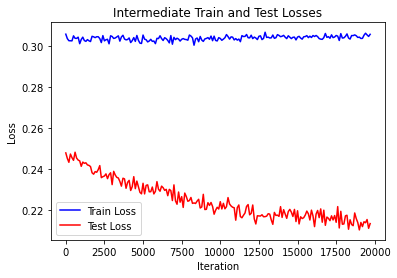

In [82]:
# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Plot train losses
ax.plot(iterations, train_losses, label='Train Loss', color='blue')

# Plot test losses
ax.plot(iterations, test_losses, label='Test Loss', color='red')

# Add labels and title
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
ax.set_title('Intermediate Train and Test Losses')

# Add a legend
ax.legend()

# Display the plot
plt.show()

## Testing

In [73]:
Z_mb = sample_Z(Test_No, Dim) 
M_mb = testM
X_mb = testX
        
New_X_mb = M_mb * X_mb + (1-M_mb) * Z_mb  # Missing Data Introduce

if use_gpu is True:
    X_mb = torch.tensor(X_mb, device='cuda')
    M_mb = torch.tensor(M_mb, device='cuda')
    New_X_mb = torch.tensor(New_X_mb, device='cuda')
else:
    X_mb = torch.tensor(X_mb)
    M_mb = torch.tensor(M_mb)
    New_X_mb = torch.tensor(New_X_mb)
    
MSE_final, Sample = test_loss(X=X_mb, M=M_mb, New_X=New_X_mb)
        
print('Final Test RMSE: ' + str(np.sqrt(MSE_final.item())))

Final Test RMSE: 0.3094698604777049


In [74]:
imputed_data = M_mb * X_mb + (1-M_mb) * Sample
print("Imputed test data:")
np.set_printoptions(formatter={'float': lambda x: "{0:0.8f}".format(x)})

if use_gpu is True:
    print(imputed_data.cpu().detach().numpy())
else:
    print(imputed_data.detach().numpy())

Imputed test data:
[[0.11013213 0.02801120 0.06470587 ... 0.00458375 0.01281538 0.14008838]
 [0.00000000 0.00000000 0.00000000 ... 0.00172492 0.00270324 0.00542929]
 [0.00000000 0.32472636 0.33435693 ... 0.00038856 0.00010012 0.00056818]
 ...
 [0.31423297 0.00000000 0.00000000 ... 0.00000000 0.30596677 0.30564378]
 [0.00000000 0.00000000 0.00000000 ... 0.00118656 0.00080096 0.00183081]
 [0.33588246 0.33183913 0.00000000 ... 0.00075261 0.00060072 0.00467172]]
